# Normality Tests and Outliers

## Introduction

In many statistical analyses, we assume that the data we are analyzing follows a **normal distribution**. This assumption is important because many statistical tests are based on the **assumption of normality**. However, in reality, data often does not follow a normal distribution perfectly. Therefore, it is important to test the normality of our data before we conduct any statistical analyses.

## Variability of Gaussian samples

The figure below illustrates the reality of Gaussian distributions in practice.  Even when values are randomly drawn from a perfect bell curve (with identical mean and standard deviation), the resulting samples rarely look perfectly symmetrical. This is especially noticeable in _small samples_ (top graphs, n=12) compared to larger ones (bottom graphs, n=130).

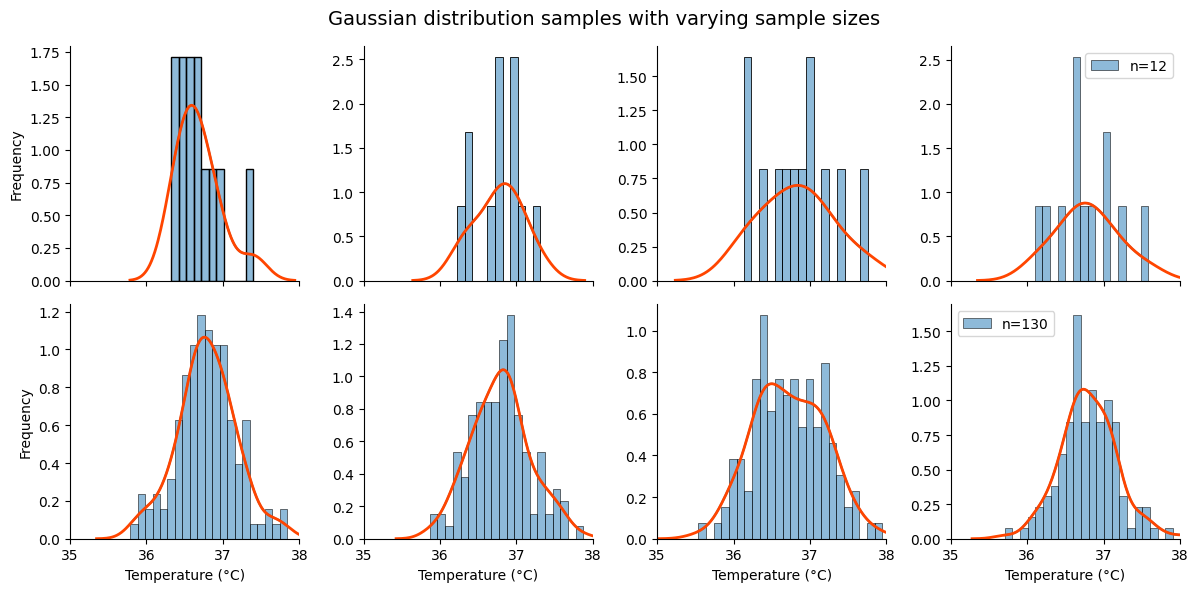

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # for easy KDE plotting

np.random.seed(111)

# Sampling parameters
mean_temp = 36.8
std_temp = 0.4
sample_sizes = [12, 130]
num_cols = 4

# Pre-generate random values (for efficiency)
random_samples = {
    size: np.random.normal(
        loc=mean_temp, scale=std_temp, size=(num_cols, size))
    for size in sample_sizes
}

# Create subplots and share x-axis for consistent scaling
fig, axes = plt.subplots(
    nrows=len(sample_sizes),
    ncols=num_cols,
    figsize=(12, 6),
    sharex=True,
)

# Main title for the entire figure
fig.suptitle(
    "Gaussian distribution samples with varying sample sizes",
    fontsize=14)

for row, size in enumerate(sample_sizes):
    for col in range(num_cols):
        ax = axes[row, col]  # Get the current subplot
        sns.histplot(  # Use seaborn for histogram with KDE
            random_samples[size][col],
            stat="density",
            binwidth=0.1,
            kde=True,
            ax=ax,
            label=f"n={size}",
        )
        # Plot the KDE separately with desired color and linewidth
        sns.kdeplot(
            random_samples[size][col],
            ax=ax,
            color='orangered',
            linewidth=2
        )
        ax.set_xlabel('Temperature (°C)')
        # Only label the y-axis for the first plot in each row
        ax.set_ylabel('Frequency' if col == 0 else "")

        # Add legend only to the last plot in each row
        if col == num_cols-1:
            ax.legend()

plt.xlim((35, 38))
sns.despine()
plt.subplots_adjust(top=0.9) # Adjust to avoid title overlap
plt.tight_layout();

Even though all samples are drawn from the same theoretical distribution, they exhibit natural variation due to random sampling. The swarm plot below vividly demonstrates this, showing how each sample can differ slightly in its shape and spread.

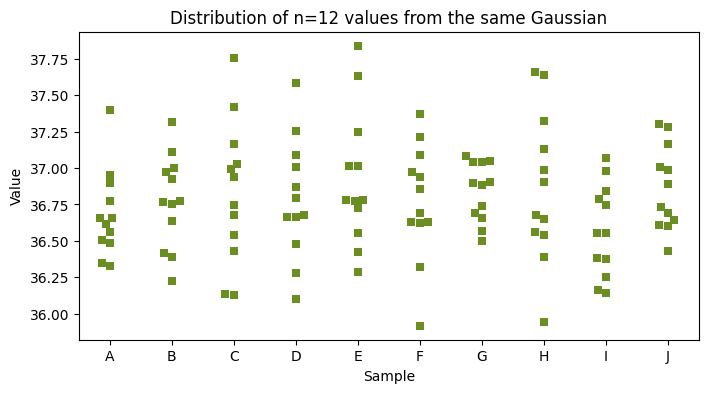

In [2]:
np.random.seed(111)

# Parameters
mean_temp = 36.8
std_temp = 0.4
labels = list("ABCDEFGHIJ")  # Cleaner way to create a list of labels
sample_size = 12

# Generate and reshape data
data = np.random.normal(
    loc=mean_temp,
    scale=std_temp,
    size=len(labels) * sample_size)
data = data.reshape((len(labels), sample_size))

# Create a list of sample labels for each data point
sample_labels = np.repeat(labels, sample_size)  # Repeat each label 12 times

# Flatten the data array
flattened_data = data.flatten()

# Create a dictionary for seaborn's data format
data_dict = {
    'Sample': sample_labels,
    'Value': flattened_data}

# Plot using seaborn with the dictionary data format
plt.figure(figsize=(8, 4))
sns.swarmplot(
    x='Sample', y='Value', data=data_dict,
    color="olivedrab",
    marker='s',
    size=6)

plt.title(
    "Distribution of n=12 values from the same Gaussian",);

## Assessing the normality of data

The assumption of normality underpins many statistical procedures. But how can we determine whether our data truly follow a Gaussian distribution? Fortunately, we have an arsenal of tools at our disposal, both graphical and statistical, to assess normality.

**Graphical methods** provide a visual first impression, helping us identify obvious departures from normality. **Statistical tests**, on the other hand, offer a more rigorous quantitative assessment.

### Q-Q plots

One of the most powerful tools for visual assessment is the **quantile-quantile (Q-Q) plot**. This plot compares the quantiles of the observed data against the quantiles of a theoretical normal distribution. If the data is perfectly normal, the points on the Q-Q plot will fall along a _straight diagonal line_.  Deviations from this line signal departures from normality. How a Q-Q Plot is Constructed:

1. Percentiles: the Q-Q plot begins by calculating the percentile rank of each value in the dataset. This tells us the proportion of values that are smaller than or equal to a given value.
2. Theoretical quantiles (Z-Scores): for each of these percentiles, the plot determines the corresponding Z-score in a standard normal distribution (mean = 0, standard deviation = 1). This Z-score indicates how many standard deviations away from the mean we would need to go in a normal distribution to reach that same percentile.
3. Predicted values: using the actual mean and standard deviation calculated from the dataset, the plot converts these theoretical Z-scores into predicted values. These are the values we would expect to see at each percentile if the data were perfectly normally distributed.
4. Plotting: finally, the Q-Q plot displays the observed data values on the y-axis and the corresponding predicted values (based on a normal distribution) on the x-axis.

#### Q-Q plots with `scipy`: normal vs. exponential

Let's use [`scipy.stats.probplot`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html) to create Q-Q plots that visually assess the normality of data sampled from normal and exponential distributions.

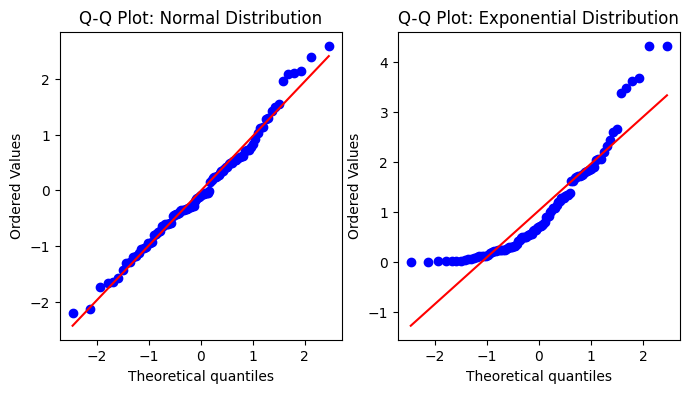

In [3]:
import scipy.stats as st

np.random.seed(111)

# Sample Generation (more descriptive variable names)
normal_data = np.random.normal(size=100)
exponential_data = np.random.exponential(size=100)

# Plotting (using a loop for conciseness and consistency)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
titles = [
    "Q-Q Plot: Normal Distribution",
    "Q-Q Plot: Exponential Distribution",
]

for i, (data, title) in enumerate(zip([normal_data, exponential_data], titles)):
    st.probplot(data, plot=axes[i])
    axes[i].set_title(title);

The Q-Q plot for the normally distributed sample closely follows a straight line, indicating normality, while the plot for the exponentially distributed sample deviates significantly from the straight line, revealing its non-normal nature.

#### Q-Q plot with `pingouin`

The `pingouin` library in Python offers a convenient function called [`qqplot`](https://pingouin-stats.org/build/html/generated/pingouin.qqplot.html) for creating Q-Q plots. It simplifies the process and provides additional features, such as confidence intervals and customizable distributions for comparison. Of note, `pingouin.qqplot` uses a _simulation-based approach_ to calculate confidence intervals, making it more robust for smaller sample sizes.

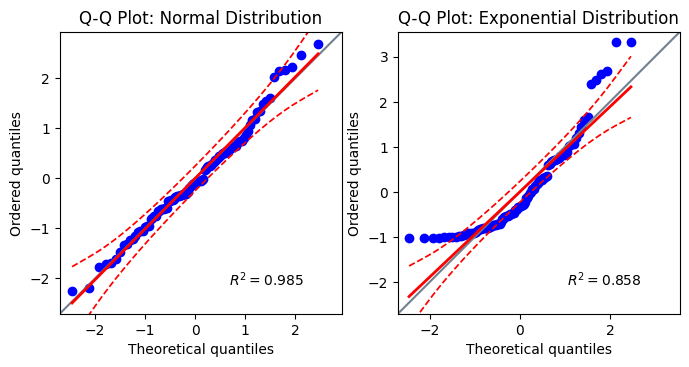

In [4]:
import pingouin as pg

np.random.seed(111)  # For reproducibility

# Sample Generation
normal_data = np.random.normal(size=100)
exponential_data = np.random.exponential(size=100)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
titles = [
    "Q-Q Plot: Normal Distribution",
    "Q-Q Plot: Exponential Distribution",
]

for i, (data, title) in enumerate(zip([normal_data, exponential_data], titles)):
    pg.qqplot(
        data,
        dist='norm', # compare the data against the normal distribution
        ax=axes[i],
        confidence=0.95, # Add 95% confidence intervals
    )
    axes[i].set_title(title);

The confidence intervals show the range within which we would expect the sample quantiles to fall if the data were truly drawn from a normal distribution.
If most of the points in the Q-Q plot fall within the confidence intervals, it provides evidence in favor of the normality assumption.
Points falling outside the confidence intervals suggest deviations from normality and warrant further investigation.

#### Alternative options for ploting Q-Q plots

Besides `scipy.stats` and `pingouin`, there are several other Python packages we can use to create Q-Q plots or similar visualizations for assessing normality:

1. [`statsmodels.graphics.gofplots.qqplot`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html): a flexible function for creating Q-Q plots, offering customization options like different line types (e.g., standardized, theoretical quantiles, regression line) and marker styles. We can also add a fitted line for better visual comparison.
2. [`sklearn.preprocessing.QuantileTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html): this transformer isn't specifically designed for Q-Q plots, but we can use it creatively. By transforming the data to a normal distribution and comparing the original and transformed quantiles, we essentially create a Q-Q plot-like visualization.
3. Manual Q-Q Plot with `matplotlib`: if we want complete control over the plot's appearance, we can create a Q-Q plot manually using Matplotlib. This involves calculating the theoretical and sample quantiles oursleves and then plotting them as a scatter plot, as shown below.

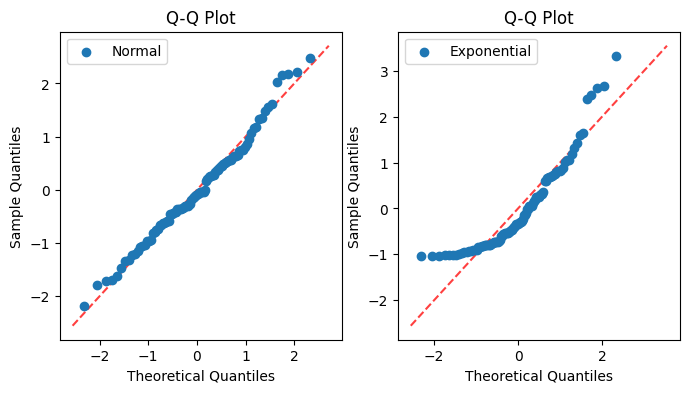

In [5]:
from scipy.stats import norm

def qq_plot(data, ax=None, **kwargs):
    """Creates a Q-Q plot using Matplotlib.

    Args:
        data (array-like): The data to plot.
        ax (matplotlib.axes.Axes, optional): The axes to plot on. If None,
        a new figure and axes will be created.
        **kwargs: Additional keyword arguments passed to ax.scatter.

    Returns:
        matplotlib.axes.Axes: The axes object on which the plot was drawn.
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Sort the data
    data_sorted = np.sort(data)

    # Theoretical quantiles
    theoretical_quantiles = norm.ppf(np.linspace(0, 1, len(data)))

    # Scatter plot of sample quantiles vs. theoretical quantiles
    ax.scatter(
        theoretical_quantiles,
        data_sorted,
        **kwargs
    )

    # Add diagonal line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()])
    ]
    ax.plot(
        lims, lims,
        'r--', alpha=0.75, zorder=0,
    )

    # Labels and title
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")
    ax.set_title("Q-Q Plot")
    ax.legend()

    return ax

# Example Usage
np.random.seed(111)

# Standardize both datasets
normal_data_std = (normal_data - np.mean(normal_data)) / np.std(normal_data)
exponential_data_std = (exponential_data - np.mean(exponential_data)) / np.std(exponential_data)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

qq_plot(
    normal_data_std,
    ax=axes[0],
    label='Normal')
qq_plot(
    exponential_data_std,
    ax=axes[1],
    label='Exponential');

Initially, i.e., without standardisation, the Q-Q plot for the exponential distribution does appear shifted upwards compared to the theoretical normal quantiles, as [shown elsewhere](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot). The exponential distribution is right-skewed, meaning it has a long tail on the right side and most of its values are concentrated on the left side, while the normal distribution is symmetrical, with values evenly distributed around the mean.

When we create a Q-Q plot with the exponential distribution against the normal distribution, we're essentially comparing two distributions with very different shapes. This leads to the observed pattern:

- Lower quantiles: the lower quantiles of the exponential distribution (values on the left side) will be smaller than the corresponding quantiles of a normal distribution. This causes the points on the Q-Q plot to fall below the diagonal line in the lower left corner.
- Upper quantiles: the upper quantiles of the exponential distribution (values on the right side) will be larger than the corresponding quantiles of a normal distribution. This pushes the points on the Q-Q plot above the diagonal line in the upper right corner, creating the appearance of an upward shift.

`pingouin.qqplot` scales the y-axis of the Q-Q plot according to the theoretical quantiles of the specified distribution (dist). When dist='norm', the y-axis is scaled to the standard normal distribution (mean=0, std=1). For non-normal distributions like the exponential, the scaling of the y-axis might not align perfectly with the range of the observed data, leading to a visual shift. One way to address this is to **standardize both the normal and exponential data** before creating the Q-Q plots. This ensures that both datasets have a mean of 0 and a standard deviation of 1, making the comparison more visually accurate.

### Statistical tests for normality

To complement these visual assessments, statistical tests offer a _more objective and quantitative_ way to evaluate whether the data significantly deviates from a normal distribution.

Statistical normality tests operate by comparing the observed data to what would be expected under a perfect normal distribution. They then quantify the discrepancy between the two, typically resulting in a _test statistic_ and a _P-value_.

- **Test statistic**: this is a numerical measure of how far the data deviates from the expected pattern of a normal distribution. _Larger test statistic values_ generally indicate a _greater departure from normality_.
- **P-value**: the P-value tells us the probability of observing a test statistic as extreme as or more extreme than the one we calculated, _assuming that the data is truly normal_. A small P-value (typically less than 0.05) suggests that the data is _unlikely_ to have come from a normal distribution, leading to the _rejection of the null hypothesis of normality_. A large P-value (typically greater than 0.05) suggests that the observed deviations from normality could be due to chance, and we fail to reject the null hypothesis of normality.

In the following subsections, we'll dive into three commonly used statistical tests for normality:

- D'Agostino-Pearson omnibus K² normality test: a versatile test that assesses both skewness (asymmetry) and kurtosis (tailedness) of the data to determine if it deviates from normality.
- Shapiro-Wilk test: often considered the most powerful test for small to medium sample sizes, it focuses on how closely the data matches the expected order statistics of a normal distribution.
- Kolmogorov-Smirnov test: a more general test that can compare the data to any theoretical distribution, not just the normal. While less powerful than the Shapiro-Wilk test for normality, it offers greater flexibility.

#### D'Agostino-Pearson omnibus K² normality test

The **D'Agostino-Pearson omnibus K-squared test** is a versatile and powerful statistical test designed to assess whether a _dataset deviates significantly from a normal distribution_. Unlike some other tests that focus on a single aspect of normality, the omnibus K² test examines both **skewness** and **kurtosis**, providing a more comprehensive evaluation.

##### Skewness and Kurtosis

- Skewness measures the _asymmetry_ of a distribution. A normal distribution is perfectly symmetrical (skewness = 0). Positive skewness indicates a long right tail, while negative skewness indicates a long left tail.
- Kurtosis measures the "tailedness" or "peakedness" of a distribution relative to a normal distribution. A normal distribution has a kurtosis of 3. A higher kurtosis (leptokurtic) implies heavier tails and a sharper peak, while a lower kurtosis (platykurtic) suggests lighter tails and a flatter peak.

    <img src="https://www.researchgate.net/publication/365035850/figure/fig4/AS:11431281179069850@1691150975936/Comparison-of-curves-for-different-skewness-and-kurtosis.png" alt="Comparison of curves for different skewness and kurtosis" style="width: 600px;"/>

    It's calculated as the "fourth standardized moment of the distribution": $\text{kurtosis} = E[(X - \mu)^4 / \sigma^4]$, with $E$ the expected value (average), $X$ a random variable, $\mu$ the mean of the distribution, and $\sigma$ the standard deviation of the distribution. For a normal distribution, when we calculate this fourth standardized moment, it turns out to be exactly 3.

In [6]:
np.random.seed(111)  # For reproducibility

# Sample Generation
normal_data = np.random.normal(size=100)
exponential_data = np.random.exponential(size=100)

# Calculate and print results
print("Distribution\tSkewness\tKurtosis")  
print("-" * 40) # Adding a separator for visual clarity
print(f"Normal\t\t{st.skew(normal_data):.3f}\t\t\
{st.kurtosis(normal_data, fisher=True):.3f}")
print(f"Exponential\t{st.skew(exponential_data):.3f}\t\t\
{st.kurtosis(exponential_data, fisher=True):.3f}")
# by subtracting 3, the Fisher definition establishes a baseline of zero for a normal distribution

Distribution	Skewness	Kurtosis
----------------------------------------
Normal		0.354		0.167
Exponential	1.374		1.654


In [7]:
# Calculate descriptive statistics using `describe`
print("Normal samples:")
print("Skewness = ", st.describe(normal_data).skewness)
print("Kurtosis = ", st.describe(normal_data).kurtosis)

Normal samples:
Skewness =  0.35440679809917
Kurtosis =  0.1665451056955929


The skewness of the normal data is close to 0 (indicating symmetry) and the excess kurtosis is close to 0 (indicating tailedness similar to a normal distribution). These values are consistent with the expectation for normally distributed data. In contrast, the skewness of _exponential data_ is positive (around 2), indicating a long right tail. The excess kurtosis is also positive (around 2), showing heavier tails than a normal distribution. These values confirm the non-normal, skewed nature of exponential data.

##### How the K² test works

1. Sample statistics: the test first calculates the sample skewness and kurtosis from the data.
2. Z-scores: these skewness and kurtosis values are then transformed into Z-scores. These Z-scores indicate how many standard deviations each value deviates from the expected value under normality (0 for skewness and 3 for kurtosis).
3. Fisher's Z-score transformation: the Z-score transformation for kurtosis specifically accounts for the fact that a normal distribution has a Fisher kurtosis of 0. It is calculated by subtracting 3 from the Pearson kurtosis. This transformation ensures that a normally distributed sample would have a kurtosis Z-score close to 0.
4. **K² statistic**: the Z-scores for skewness and kurtosis are squared and summed to form the omnibus K-squared statistic.
5. P-value: the K² statistic is approximately _chi-square_ distributed with 2 degrees of freedom under the null hypothesis of normality. This allows us to calculate a P-value, which represents the probability of observing a K² statistic as extreme as or more extreme than the one calculated from the data, assuming normality holds true.
   - A small p-value (typically less than 0.05) indicates that the observed skewness and/or kurtosis are significantly different from what would be expected in a normal distribution, providing evidence against the normality assumption.
   - A large p-value suggests that the data are consistent with normality (i.e., we fail to reject the null hypothesis).

##### Manual implementation of the K² test

We can implement the D'Agostino-Pearson test from scratch using NumPy and SciPy functions. This involves calculating skewness and kurtosis, transforming them into Z-scores, and then computing the K2 statistic and its associated p-value using the chi-square distribution.

In [8]:
from scipy.stats import skew, kurtosis, chi2

def dagostino_pearson_test(data):
    """Performs the D'Agostino-Pearson omnibus K2 test for normality.

    Args:
        data (array-like): The data to test for normality.

    Returns:
        statistic: The K2 test statistic.
        p_value: The p-value for the hypothesis test.
    """
    n = len(data)
    if n < 8:
        raise ValueError("Sample size must be at least 8 for the test.")

    # Calculate sample skewness and kurtosis (Fisher's definition)
    s = skew(data)
    k = kurtosis(data, fisher=True)  

    # Calculate intermediate terms
    y = s * np.sqrt((n + 1) * (n + 3) / (6 * (n - 2)))
    beta_two = (
        (3 * (n**2 + 27*n - 70) * (n + 1) * (n + 3))
        /
        ((n - 2) * (n + 5) * (n + 7) * (n + 9))
    )
    w_two = -1 + np.sqrt(2 * (beta_two - 1))
    delta = 1 / np.sqrt(np.log(np.sqrt(w_two)))
    alpha = np.sqrt(2 / (w_two - 1))
    
    # Calculate Z-scores
    z_skew = delta * np.log(y / alpha + np.sqrt((y / alpha)**2 + 1))
    z_kurt = (k / (2 * np.sqrt(3 * (n - 1) / ((n + 1) * (n + 3)))))

    # Calculate K2 statistic
    k2 = z_skew**2 + z_kurt**2

    # Calculate p-value using chi-square distribution with 2 degrees of freedom
    p_value = 1 - chi2.cdf(k2, 2)

    return k2, p_value

# Example usage with consistent seed
np.random.seed(111)  # Same seed for both samples
normal_data = np.random.normal(size=100)
exponential_data = np.random.exponential(size=100)

for data, sample_type in zip([normal_data, exponential_data], ["Normal", "Exponential"]):
    k2, pval = dagostino_pearson_test(data)
    print(f"{sample_type:<12} D'Agostino-Pearson K²={k2:.2f}  p-value={pval:.3f}")

Normal       D'Agostino-Pearson K²=2.50  p-value=0.286
Exponential  D'Agostino-Pearson K²=46.43  p-value=0.000


##### K² test with `scipy.stats.normaltest`

The D'Agostino-Pearson omnibus K² test is a powerful normality test that assesses both skewness and kurtosis, suitable for _various sample sizes_, but it may be _less sensitive_ to deviations in the distribution's center and _overly sensitive to outliers_ in _small samples_. Let's demonstrate the [`scipy.stats.normaltest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html) function in action to assess normality concretely.

In [9]:
np.random.seed(111)

normal_data = np.random.normal(size=100)
exponential_data = np.random.exponential(size=100)

# Function to perform the test and print results
def test_and_print(data, sample_type):
    k2, pval = st.normaltest(data)
    print(f"{sample_type:<12} D'Agostino-Pearson K²={k2:.2f}  P-value={pval:.3f}")

# Perform tests and print results (using the function)
print("\n--- D'Agostino-Pearson Omnibus K² Test ---")
test_and_print(normal_data, "Normal:")
test_and_print(exponential_data, "Exponential:")


--- D'Agostino-Pearson Omnibus K² Test ---
Normal:      D'Agostino-Pearson K²=2.70  P-value=0.259
Exponential: D'Agostino-Pearson K²=29.04  P-value=0.000


The P-value for the normal data is high (0.900), indicating we fail to reject the null hypothesis of normality. This is consistent with the data being sampled from a normal distribution. In contrast, the P-value for the exponential data is very small (0.000), indicating we strongly reject the null hypothesis of normality. This is expected, as exponential data is not normally distributed.

<u>Note</u>: Minor differences in results between the manual D'Agostino-Pearson implementation and `scipy.stats.normaltest` are likely due to floating-point arithmetic and rounding errors inherent in numerical calculations, implementation details such as optimizations or approximations used in `scipy.stats`, as well as software versions and potential updates to the algorithms in `scipy.stats`. Don't overinterpret small variations, especially if both lead to the same conclusion about normality. Focus on practical significance and, if uncertain, use additional tests to confirm the findings. We can generally trust `scipy.stats.normaltest` as it's well-maintained and widely used, but the manual implementation is a valuable learning exercise and cross-check ;-)

#### Shapiro-Wilk test

The Shapiro-Wilk test stands out as a powerful and widely used statistical test for assessing normality, particularly for _small to moderate sample sizes_ (up to 5000 data points). The [study from Razali and Wah (2011)](https://web.archive.org/web/20150630110326/http://instatmy.org.my/downloads/e-jurnal%202/3.pdf) demonstrated its slightly superior power compared to other normality tests, making it a preferred choice in many scenarios.

##### How the Shapiro-Wilk test works

At its core, the Shapiro-Wilk test _compares the observed distribution_ of the data to an _idealized normal distribution_. Here's a simplified breakdown:

1. Sorting: the test starts by sorting the data points from smallest to largest.
2. Expected values: it then calculates the values we would expect to see at each rank (percentile) if the data were perfectly normally distributed. These expected values are based on the properties of the _standard normal distribution_ (mean = 0, standard deviation = 1).
3. **Correlation**: the test assesses the correlation between the observed sorted values and their corresponding expected values. If the data is perfectly normal, this correlation should be very high.
4. **Test statistic (W)**: the correlation is transformed into a test statistic called $W$, which ranges from 0 to 1. Values closer to 1 indicate a better fit to normality.
5. P-value: finally, a P-value is calculated based on the W statistic. A small P-value (typically < 0.05) suggests that the observed data are _unlikely to have come from a normal distribution_, leading to the rejection of the null hypothesis of normality.

While modern algorithms extend the Shapiro-Wilk test's applicability to 5000 data points, it's still _not ideal for very large samples_. For samples exceeding this limit, consider alternative tests like the D'Agostino-Pearson omnibus K2 test. Another limitation is that the Shapiro-Wilk test is generally powerful, but it might not be the most sensitive to specific types of deviations from normality, such as those affecting only the tails of the distribution.

##### Application of `scipy.stats.shapiro`

Let's demonstrate how to apply the Shapiro-Wilk test in Python using the `scipy.stats` module, in particular the [`shapiro` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html) and interpret its results to gain deeper insights into the normality of the data.

In [10]:
np.random.seed(111) # for reproducibility

# Sample Generation
normal_data = np.random.normal(size=100)
exponential_data = np.random.exponential(size=100)

# Function to perform the Shapiro-Wilk test and print results
def shapiro_wilk_test(data, sample_type):
    statistic, p_value = st.shapiro(data)
    print(f"{sample_type:<12} Shapiro-Wilk W = {statistic:.3f}, P-value = {p_value:.3f}")
    # print(f"{' ':<15} {'(Reject H0 if p < 0.05)':>30}")  # H0: Data is normal

# Perform Shapiro-Wilk test and print results
print("\n--- Shapiro-Wilk Test ---")
shapiro_wilk_test(normal_data, "Normal:")
shapiro_wilk_test(exponential_data, "Exponential:")


--- Shapiro-Wilk Test ---
Normal:      Shapiro-Wilk W = 0.984, P-value = 0.263
Exponential: Shapiro-Wilk W = 0.855, P-value = 0.000


The W statistic for the normal data (0.987) is close to 1, indicating a good fit to normality. Combined with the high P-value, this strongly supports the hypothesis that the data is normally distributed. In contrast, the W statistic for the exponential data (0.803) is lower, suggesting a less good fit to normality. Along with the extremely low P-value, this provides strong evidence against the normality of the exponential data.

#### Normality tests using `pingouin`

Pingouin's [`normality` function](https://pingouin-stats.org/build/html/generated/pingouin.normality.html) actually performs both the Shapiro-Wilk test and the D'Agostino-Pearson test. We can easily access the results for either test from the returned dataframe.

In [11]:
import pingouin as pg

np.random.seed(111)  # For reproducibility

# Sample Generation
normal_data = np.random.normal(size=100)
exponential_data = np.random.exponential(size=100)

# Function to perform tests and print results
def normality_tests(data, sample_type):
    print("\n--- Normality Tests for", sample_type, "---")
    print(f"{'Test':<20} {'W':<8} {'P-value':<6}")

    # Shapiro-Wilk Test
    shapiro_results = pg.normality(data, method='shapiro')
    print(f"{'Shapiro-Wilk':<20} {shapiro_results['W'][0]:<8.3f} \
{shapiro_results['pval'][0]:<6.3f}")

    # D'Agostino-Pearson Test
    dagostino_results = pg.normality(data, method='normaltest')
    print(f"{'D\'Agostino-Pearson':<20} {dagostino_results['W'][0]:<8.3f} \
{dagostino_results['pval'][0]:<6.3f}")

    print("-" * 40)

# Perform tests and print results
normality_tests(normal_data, "Normal Data")
normality_tests(exponential_data, "Exponential Data")


--- Normality Tests for Normal Data ---
Test                 W        P-value
Shapiro-Wilk         0.984    0.263 
D'Agostino-Pearson   2.703    0.259 
----------------------------------------

--- Normality Tests for Exponential Data ---
Test                 W        P-value
Shapiro-Wilk         0.855    0.000 
D'Agostino-Pearson   29.044   0.000 
----------------------------------------


#### Omnibus test for normality using `statsmodels`

The [`omni_normtest` function](https://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.omni_normtest.html) offers a convenient way to assess normality in the data. The term "omnibus" means "including or covering many things." In the context of normality testing, an omnibus test combines multiple aspects of normality into a single test statistic. The `omni_normtest` function in `statsmodels` does this by evaluating both skewness and kurtosis, similar to the D'Agostino-Pearson test, by incorporating three different tests, i.e., the Jarque-Bera test, the skewness test and the kurtosis test.

The function calculates the test statistics for each of the three individual tests, and then combines the P-values from these individual tests using Fisher's method to obtain an overall omnibus test statistic (chi-square distributed). Finally, the test calculates a single P-value based on this omnibus test statistic. This P-value indicates the overall probability of observing the combined test results if the data were truly normally distributed.

In [12]:
import statsmodels.api as sm

np.random.seed(111)  # For reproducibility

# Sample Generation
normal_data = np.random.normal(size=100)
exponential_data = np.random.exponential(size=100)

# Function to perform the omnibus test and print results
def omnibus_normality_test(data, sample_type):
    omnibus_stat, omnibus_pvalue = sm.stats.stattools.omni_normtest(data)

    print(f"\n--- Omnibus Normality Test for {sample_type} ---")
    print(f"Omnibus Statistic: {omnibus_stat:.3f}")
    print(f"Omnibus p-value: {omnibus_pvalue:.3f}")
    # print(f"{'(Reject H0 if p < 0.05)':>30}")  # H0: Data is normal

# Perform tests and print results
omnibus_normality_test(normal_data, "Normal Data")
omnibus_normality_test(exponential_data, "Exponential Data")


--- Omnibus Normality Test for Normal Data ---
Omnibus Statistic: 2.703
Omnibus p-value: 0.259

--- Omnibus Normality Test for Exponential Data ---
Omnibus Statistic: 29.044
Omnibus p-value: 0.000


It's important to note that the omni_normtest function is not the most powerful test for normality, especially for smaller sample sizes. For smaller samples, the Shapiro-Wilk test is often preferred. Moreover, the omnibus nature of this test makes it difficult to pinpoint exactly which aspect of normality (skewness or kurtosis) is being violated if the null hypothesis is rejected.

#### Kolmogorov-Smirnov test

The Kolmogorov-Smirnov (K-S) test is a versatile **nonparametric test** used to assess whether two samples are drawn from the same distribution or whether a single sample follows a specified theoretical distribution. Unlike parametric tests like the t-test, which primarily focus on differences in location (means), the K-S test is sensitive to differences in both location, scale (spread), and shape, making it a more comprehensive tool for comparing distributions.

The K-S test comes in two flavors:

- One-Sample K-S test: compares the empirical distribution function (ECDF) of the observed data to the cumulative distribution function (CDF) of a reference distribution (e.g., normal, exponential, uniform). This helps us determine if the sample data likely comes from the specified distribution.
- Two-Sample K-S test: compares the ECDFs of two independent samples to assess whether they are likely drawn from the same underlying distribution, even if that distribution is unknown.

The core idea behind the K-S test is simple yet powerful: it quantifies the _maximum vertical distance_ (absolute difference) between the two cumulative distribution functions being compared. This **maximum distance** is the **K-S test statistic**, often denoted as $D$. A larger K-S statistic indicates a _greater discrepancy_ between the two distributions, providing stronger evidence against the null hypothesis of identical distributions.

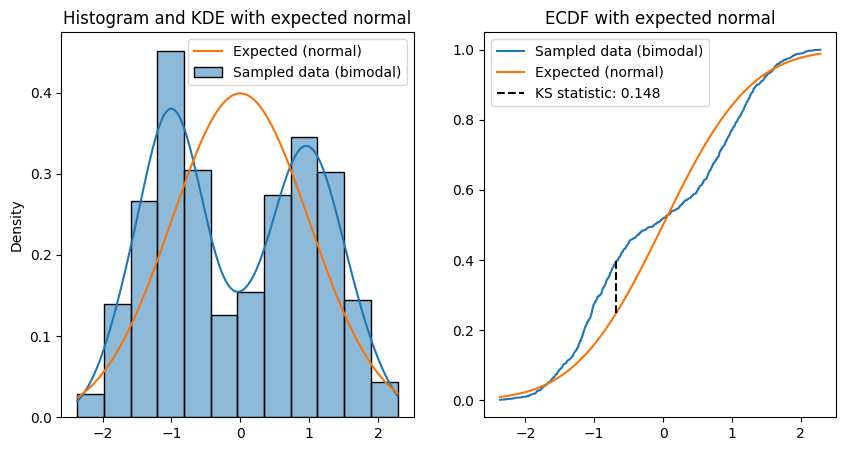

In [13]:
np.random.seed(111)  # for reproducibility

# Sample Generation (bimodal distribution)
sample_size = 1000
sample = (
    np.random.randn(sample_size)
    * 0.5
    + 1
    - 2 * (np.random.random(sample_size) > 0.5)
)

# ECDF Function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of values."""
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y

# Calculate ECDFs
sample_x, sample_ecdf = ecdf(sample)
normal_cdf = norm.cdf(sample_x)

# KS Statistic
ks_stat = np.max(np.abs(normal_cdf - sample_ecdf))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Histogram and KDE Plot
sns.histplot(
    sample,
    label="Sampled data (bimodal)",
    stat="density",
    kde=True,
    ax=axes[0],
)
sns.lineplot(
    x=sample_x,
    y=norm.pdf(sample_x),
    color="xkcd:orange",
    label="Expected (normal)",
    ax=axes[0],
)
axes[0].set_title(
    "Histogram and KDE with expected normal",)
axes[0].legend()


# ECDF Plot
sns.lineplot(
    x=sample_x,
    y=sample_ecdf,
    label="Sampled data (bimodal)",
    ax=axes[1],
)
sns.lineplot(
    x=sample_x,
    y=normal_cdf,
    color="xkcd:orange",
    label="Expected (normal)",
    ax=axes[1],
)

# Highlight the max difference (KS statistic)
max_diff_idx = np.argmax(
    np.abs(normal_cdf - sample_ecdf)
)
axes[1].vlines(
    x=sample_x[max_diff_idx],
    ymin=min(sample_ecdf[max_diff_idx], normal_cdf[max_diff_idx]),
    ymax=max(sample_ecdf[max_diff_idx], normal_cdf[max_diff_idx]),
    colors="black",
    linestyles="dashed",
    label=f"KS statistic: {ks_stat:.3f}"
)

axes[1].set_title(
    "ECDF with expected normal",)
axes[1].legend();

We can perform the (one-sample) K-S test using [`scipy.stats.kstest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html) as shown below.

The test statistic (D) measures the maximum absolute difference between the empirical cumulative distribution function (ECDF) of the sample and the cumulative distribution function (CDF) of the standard normal distribution. A larger D value suggests a greater discrepancy from normality. In addition, the P-value is the probability of observing a test statistic as extreme as or more extreme than the calculated D, assuming the null hypothesis (normality) is true. A small p-value (typically < 0.05) provides evidence against normality.

In [14]:
np.random.seed(111)  # For reproducibility

# Sample Generation (bimodal distribution)
sample_size = 1000
sample = np.random.randn(sample_size) * 0.5 + 1 - 2 * (np.random.random(sample_size) > 0.5)

# Perform the one-sample Kolmogorov-Smirnov test
ks_statistic, p_value = st.kstest(
    sample,
    'norm', # 'norm' specifies the normal distribution
) 

# Output the results with clear formatting
print("\n--- One-Sample Kolmogorov-Smirnov Test ---")
print(f"Null Hypothesis (H0): sample comes from a normal distribution")
print(f"Test statistic (D): {ks_statistic:.3f}")
print(f"P-value: {p_value:.5f}")
if p_value < 0.05:  # Typical significance level
    print("Reject H0: evidence suggests the sample is NOT normally distributed")
else:
    print("Fail to reject H0: insufficient evidence to conclude the sample \
is not normally distributed")


--- One-Sample Kolmogorov-Smirnov Test ---
Null Hypothesis (H0): sample comes from a normal distribution
Test statistic (D): 0.148
P-value: 0.00000
Reject H0: evidence suggests the sample is NOT normally distributed


Given that the sample is intentionally generated as a bimodal distribution, we expect the P-value to be very small, indicating strong evidence against the null hypothesis of normality. This would align with the visual inspection of the ECDF plots, where the sample distribution clearly deviates from the normal curve.

The K-S test finds applications in various fields:

- Goodness-of-fit testing: assessing whether data fits a particular theoretical distribution (e.g., testing for normality).
- Comparing sample distributions: determining if two groups differ significantly in their underlying distributions.
- Model validation: evaluating the fit of statistical models by comparing the predicted and observed distributions.
- Quality control: testing the uniformity of random number generators.

#### Additional normality tests

In addition to the D'Agostino-Pearson, Shapiro-Wilk, and Kolmogorov-Smirnov tests, several other statistical tests can assess normality:

- [Anderson-Darling test](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test): a modification of the Kolmogorov-Smirnov test that is often more powerful, particularly for detecting deviations in the tails. (Available in [`scipy.stats.anderson`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html)).
- [Lilliefors test](https://en.wikipedia.org/wiki/Lilliefors_test): a corrected version of the Kolmogorov-Smirnov test that is more appropriate when the population parameters are unknown. (Available in [`statsmodels.stats.diagnotic.lilliefors`](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.lilliefors.html)).
- [Jarque-Bera test](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test): similar to D'Agostino-Pearson, but less powerful, especially for small samples. Often used in econometrics. (Available in [`scipy.stats.jarque_bera`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html)).
- [Shapiro-Francia test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Francia_test): a computationally lighter alternative to Shapiro-Wilk for large samples (typically > 50). (Available in the [`sfrancia` package](https://pypi.org/project/sfrancia/#data)).
- [Cramér-von Mises test](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93von_Mises_criterion): measures the overall difference between the observed and theoretical distributions. (Available in [`scipy.stats.cramervonmises` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cramervonmises.html)).

Choosing a Test:

- Shapiro-Wilk is a good general-purpose test.
- Shapiro-Francia or Anderson-Darling are suitable for large samples.
- Shapiro-Wilk is better for small samples.
- Anderson-Darling is sensitive to tail deviations.
- Lilliefors is suitable when parameters are unknown.
- Jarque-Bera is often used in time series and econometrics.

Combining visual inspection with multiple tests is recommended for a well-rounded assessment of normality.

## Outliers

An outlier is a data point that significantly deviates from the overall pattern of the dataset, raising questions about its origin and validity. It's a value so extreme that it appears to belong to a different population than the rest of the data. Outliers can arise from various sources, both benign and problematic:

- Data entry errors: typos, miscalculations, or incorrect measurements can easily introduce outliers. Or it can be a missing value encoded as '999'.
- Biological diversity: in biological data, outliers can reflect genuine _natural variation_. Some individuals simply fall at the extreme ends of a trait's distribution.
- Random chance: even in perfectly controlled experiments, statistical fluctuations can occasionally produce extreme values.
- Experimental mistakes: equipment malfunctions, protocol deviations, or contamination can lead to erroneous data points.
- Invalid assumptions: sometimes, what appears to be an outlier under one statistical model might fit perfectly under a different model. For example, data that seems like an outlier in a normal distribution might be entirely expected in a lognormal distribution.

### Graphical approaches for outlier detection

#### General-purpose outlier detection methods

For effectively detecting outliers in the data, we may combine both graphical and statistical methods. First of all, we need to understand the data:

- Contextual knowledge: leverage the domain expertise to define what constitutes an "outlier" in the context of the specific data and research question. Is it an extreme value, an unexpected pattern, or something else?
- Data exploration: conduct a thorough exploratory data analysis (EDA) to understand the central tendency, spread, and overall shape of the data. This will help identify reasonable ranges and establish a baseline for outlier detection.

Visual inspection can be achieved using different tools:

- Univariate data:
    - Histograms: looking for isolated bars or gaps in the distribution.
    - **Box plots**: identifying points that fall outside the whiskers ($1.5 \times \text{IQR}$ from the quartiles).
    - Normal Q-Q plots: checking if points deviate significantly from the diagonal line, especially in the tails.
- Multivariate data:
    - Scatter plots: visualizing relationships between pairs of variables and look for isolated points.
    - Scatterplot matrices: examining multiple pairwise relationships simultaneously to spot outliers across different dimensions.

#### The case of log-normal data

Sometimes, data doesn't fit the familiar bell-shaped curve of a normal distribution. One common scenario is **log-normal** data, where the logarithms of the values follow a normal distribution. This type of distribution often arises in situations where the data represents _multiplicative_ processes or where the values are inherently _positive and skewed to the right_. This skew can create a _misleading impression of outliers_ when viewed on a linear scale.

To illustrate the characteristics of log-normal data and the potential misidentification of outliers, consider the following example. We've generated 10 random samples (labeled A-J), each containing 15 values drawn from the same log-normal distribution.

In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

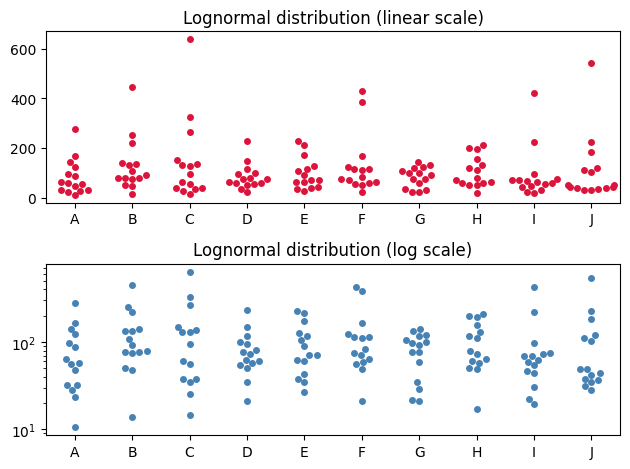

In [16]:
np.random.seed(111) # for reproducibility

# Parameters
mean = np.log(80) # Mean of the underlying normal distribution 
# (calculated from the desired median of the lognormal distribution)
sigma = 0.8       # Standard deviation of the underlying normal distribution
labels = list("ABCDEFGHIJ")
sample_size = 15

# Generate data
data = np.random.lognormal(
    mean,
    sigma,
    size=(len(labels), sample_size)
)

# Flatten and create labels for seaborn
flattened_data = data.flatten()
sample_labels = np.repeat(labels, sample_size)
data_dict = {
    'Sample': sample_labels,
    'Value': flattened_data}

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1,)

# Plot 1: Linear Scale
sns.swarmplot(
    x=np.tile(labels, sample_size),
    y=data.flatten(),
    color="crimson",
    # size=4,
    ax=axes[0],
)
axes[0].set_title(
    "Lognormal distribution (linear scale)",)

# Plot 2: Log Scale
sns.swarmplot(
    x=np.tile(labels, sample_size),
    y=data.flatten(),
    color="steelblue",
    # size=4,
    ax=axes[1],
)
axes[1].set_yscale("log")
axes[1].set_title("Lognormal distribution (log scale)",)

plt.tight_layout();

The top swarm plot shows the raw, untransformed data. Notice the _rightward skew_, with most values clustered towards the lower end and a few extreme values stretching out the tail. On this linear scale, these extreme values might be mistakenly labeled as outliers.

However, the bottom swarm plot reveals a different story. Here, the y-axis is transformed to a _logarithmic scale_. The points now align more closely along a horizontal line, resembling the pattern expected from a normal distribution. This visual transformation confirms that the logarithms of the data are approximately normally distributed, a hallmark of log-normal data. Crucially, the values that appeared as outliers on the linear scale are now seen as part of the normal variation within the log-transformed distribution.

Understanding whether the data is log-normal has important implications for the analysis:

- Transformation for normality: if we need to apply statistical methods that assume normality, we might be able to transform log-normal data into a normal distribution by taking the logarithm of each value. This can open up a wider range of analysis techniques.
- Interpreting descriptive statistics: for log-normal data, the **geometric mean** is often a more appropriate measure of central tendency than the arithmetic mean, which can be heavily influenced by extreme values.
- Modeling: log-normal distributions are frequently used to model phenomena like income distribution, stock prices, and biological growth processes.
- Avoiding misinterpretation of outliers: as demonstrated in the plots, careful consideration of the appropriate scale is crucial when identifying outliers in log-normal data. Blindly applying outlier detection methods on the raw data can lead to erroneous conclusions.

#### Cook's distance and leverage

**Cook's distance** is a statistical measure of the influence of a data point on a _regression model_, i.e., it is not applicable to general outlier detection in other types of data without a regression context. It's _not a visual test in itself_, but it can be used to inform visual inspection. Cook's distance is calculated based on the **residuals** (the differences between the observed and predicted values) and the **leverage** (how far the predictor values are from their mean) of each data point in a regression model. Of note, a high leverage point can have a high Cook's distance even if its residual isn't that large. Higher Cook's distance values indicate that a data point has a _greater influence on the model's fitted values_.

We can plot Cook's distances against data point indices or predictor values to visually identify highly influential data points that significantly modify the regression coefficients. For example, we can leverageg the [`statsmodels.stats.outliers_influence.OLSInfluence` class](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.OLSInfluence.html) to calculate outlier and influence measures on the [R `iris` dataset](https://search.r-project.org/CRAN/refmans/MVTests/html/iris.html). While often used for classification, e.g., for machine learning, the `iris` dataset includes continuous variables like sepal length and width that we can use for regression analysis.

In [17]:
# load the dataset
iris = sm.datasets.get_rdataset("iris").data

# rename columns to avoid PatsyError
iris.columns = iris.columns.str.replace(".", "_")

# create one exagerated outlier
iris.loc[50, 'Petal_Length'] = (
    iris['Petal_Length'].mean() + 3 * iris['Petal_Length'].std()
)

iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal_Length  150 non-null    float64
 1   Sepal_Width   150 non-null    float64
 2   Petal_Length  150 non-null    float64
 3   Petal_Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


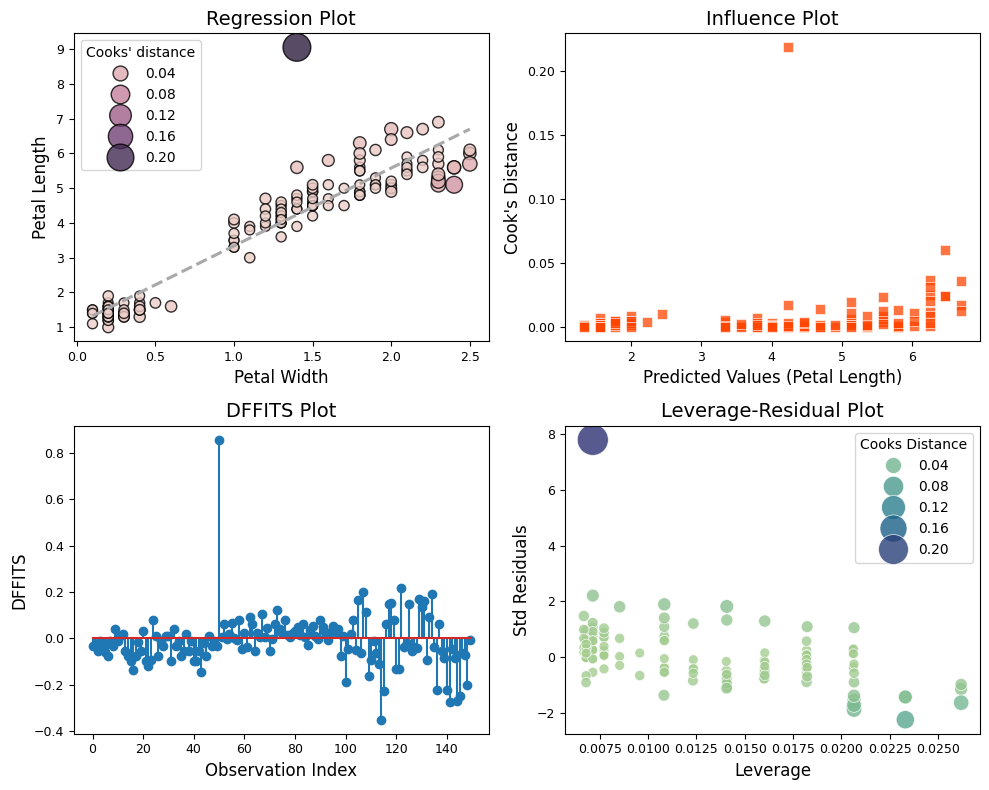

In [18]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence

# fit the regression model using statsmodels library 
model = ols(
    formula="Petal_Length ~ Petal_Width",
    data=iris
).fit()

# Calculate Cooks' distance, leverage, DFFITS, and standardized residuals
influence = OLSInfluence(model)

cooks_distance = influence.cooks_distance[0]
leverage = influence.hat_matrix_diag
dffits = influence.dffits[0]
standardized_residuals = influence.resid_studentized_internal
predicted_values = model.fittedvalues

# Set font sizes for title and labels before creating the plot
title_fontsize = 14
label_fontsize = 12
ticks_fontsize = 9

plt.rcParams.update({
    'axes.titlesize': title_fontsize, 
    'axes.labelsize': label_fontsize,
    'xtick.labelsize': ticks_fontsize,
    'ytick.labelsize': ticks_fontsize,
})

# Create a figure with four subplots sharing a y-axis
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Subplot 1: Regression Plot
sns.scatterplot(
    x='Petal_Width',
    y='Petal_Length',
    data=iris,
    hue=cooks_distance,
    size=cooks_distance,
    sizes=(50, 400),
    alpha=.8,
    edgecolor='black',
    linewidth=1,
    ax=axes[0, 0],
)
sns.regplot(
    x='Petal_Width',
    y='Petal_Length',
    data=iris,
    scatter=False,
    ax=axes[0, 0],
    ci=False,
    line_kws={'color': 'darkgrey', 'ls': '--'}
)
axes[0, 0].set_xlabel("Petal Width")
axes[0, 0].set_ylabel("Petal Length")
axes[0, 0].set_title('Regression Plot')
axes[0, 0].legend(title="Cooks' distance")


# Subplot 2: Cooks' distance vs. Predicted Values
sns.scatterplot(
    x=predicted_values,
    y=cooks_distance,
    color='orangered',
    ax=axes[0, 1],
    s=50,
    marker='s',
    alpha=.75,
)
axes[0, 1].set_title("Influence Plot")
axes[0, 1].set_xlabel("Predicted Values (Petal Length)")
axes[0, 1].set_ylabel("Cook's Distance")


# Subplot 3: DFFITS Plot
axes[1, 0].stem(dffits)
axes[1, 0].set_title('DFFITS Plot')
axes[1, 0].set_xlabel('Observation Index')
axes[1, 0].set_ylabel('DFFITS')


# Subplot 4: Influence Plot (Bubble Plot)
influence_data = pd.DataFrame({
    'Leverage': leverage,
    'Std Residuals': standardized_residuals,
    'Cooks Distance': cooks_distance,
})

sns.scatterplot(
    x='Leverage',
    y='Std Residuals',
    data=influence_data,
    size='Cooks Distance',
    sizes=(50, 500),
    alpha=.8,
    hue='Cooks Distance',
    palette='crest',
    ax=axes[1,1],
)
axes[1, 1].set_title('Leverage-Residual Plot')

# Display all plots
plt.tight_layout();

The four plots - regression with Cook's distance as hue, Cook's distance vs. predicted values, DFFITS plot, and leverage-residual plot - offer complementary perspectives on the impact of the outlier in the regression analysis.

1. Regression Plot with Cook's Distance as Hue
    - The outlier is immediately noticeable due to its distinct color, indicating a high Cook's distance.
    - Visually, we can see how the outlier pulls the regression line towards itself, demonstrating its disproportionate influence on the fitted values.
2. Cook's Distance vs. Predicted Values
    - The outlier stands out with a much higher Cook's distance than other points.
    - Its position on the x-axis (predicted values) might give clues about its nature. For instance, if it's far from the other predicted values, it suggests that the outlier is not only influential but also _poorly predicted_ by the model.
3. DFFITS Plot
    - The outlier is likely the point with the highest absolute DFFITS value, indicating that its _removal would lead to a substantial change_ in its own predicted value.
    - This plot confirms the outlier's influence on the model's predictions.
4. Leverage-Residual Plot (Influence Plot)
    - The outlier appears in the upper right or lower right quadrant, indicating high leverage and a _large residual_.
    - This plot highlights how the outlier is both unusual in its predictor values (leverage) and has a large discrepancy between its observed and predicted values (residual), making it a particularly influential point.

The consistent identification of the outlier across all four plots underscores its strong influence on the regression model. This outlier is not merely an extreme value but also exerts significant leverage, affecting both the overall fit of the model and individual predictions.

There's no strict cutoff for what constitutes a "high" Cook's distance. It depends on the sample size and the specific context of the analysis. A common rule of thumb is to investigate points with a Cook's distance greater than $4/n$ (where $n$ is the sample size), but it's also essential to examine the plot visually to identify any points that stand out from the rest, regardless of the numerical threshold.

Some statisticians suggest investigating data points with a Cook's distance greater than 1 divided by the square root of the sample size ($1/\sqrt{n}$). This threshold is generally more conservative than the $4/n$ rule and might be more appropriate for smaller sample sizes. In another rule, the threshold is $2 \times \sqrt{(p+1)/n}$, with $p$ the number of predictor variables on the regression model. Neither rule is a definitive cut-off. They are meant as guidelines to help us identify points that warrant further investigation.

### Statistical outlier detection

#### Grubbs' test

While visual inspection provides a valuable first look, statistical tests offer a more objective way to identify outliers. One such test, well-suited for detecting a single outlier in a _normally distributed dataset_, is **Grubbs' test**.

Grubbs' test calculates a test statistic ($G$) that quantifies how many standard deviations the most extreme value in the dataset is from the sample mean. While similar in concept to z-scores and t-statistics, Grubbs' test statistic uses a specific distribution (the studentized maximum modulus distribution) to determine its critical values and p-values. It's worth noting that the term "extreme studentized deviate (ESD) test" is sometimes used interchangeably with Grubbs' test, particularly when testing for multiple outliers.

1. Null hypothesis: the null hypothesis (H0) states that there are no outliers in the data.
2. Test statistic: Grubbs' test calculates a test statistic ($G$) based on the _maximum deviation_ of the data point from the _sample mean_, divided by the sample standard deviation ($G = \max_{i} \left|\frac{y_{i} − \bar{y}}{s}\right|$).
3. Critical value: this test statistic is compared to a critical value that depends on the desired significance level (e.g., 0.05) and the sample size. For example the critical G values for _one-sided test_ can be found in the table below:

   <img src="https://cdn.slidesharecdn.com/ss_thumbnails/statisticstablesgrubbstest-150209143458-conversion-gate02-thumbnail-4.jpg?cb=1423492541" alt="Critical Values of Grubbs' Statistic (G)" style="width: 600px;"/>
4. Decision:
    - If the test statistic is greater than the critical value, we reject the null hypothesis and conclude that the most extreme value is a significant outlier.
    - If the test statistic is less than or equal to the critical value, we fail to reject the null hypothesis, suggesting that the extreme value may not be a true outlier.

Let's put Grubbs' test to work on a concrete example. We generate data from a normal distribution, intentionally introduce an exaggerated outlier, and then calculate the Grubbs' statistic to see if the test can successfully detect it.

In [19]:
def grubbs_gmax(n, alpha=0.05, onesided=False):
    """
    Critical value for Grubbs' test for outlier.

    >>> grubbs_gmax(n=8, alpha=0.05, onesided=False)
    2.126645087195626
    >>> grubbs_gmax(n=8, alpha=0.05, onesided=True)
    2.031652001549952
    See also:
    https://ycopin.pages.in2p3.fr/Informatique-Python/Annales/22-grubbs/exam22_corrige.html
    """

    sl = alpha / n    # one-sided
    if not onesided:  # two-sided
        sl /= 2

    # Critical value (squared) of the t distribution w/ n-2 DoF and
    # significance level sl
    cv2 = st.t.isf(sl, n - 2) ** 2
    gmax = (n - 1) * np.sqrt(cv2 / (n - 2 + cv2) / n)

    return gmax

In [20]:
# Generate normal sample with an outlier
np.random.seed(123)  # For reproducibility
sample_size = 100
sample = np.random.normal(0, 1, sample_size)
sample[0] = 5  # Introduce an exaggerated outlier

# Grubbs' Test (Manual Implementation)
def grubbs_test_manual(data, alpha=0.05):
    """Performs a two-sided Grubbs' test manually."""

    sample_mean = np.mean(data)
    sample_std = np.std(data, ddof=1)  # Use ddof=1 for sample standard deviation

    # Calculate G statistic (using absolute value for two-sided test)
    G = np.max(np.abs(data - sample_mean)) / sample_std

    # Critical value from Grubbs' table or using t-distribution
    G_critical = grubbs_gmax(n=len(data), alpha=alpha, onesided=False)

    return G, G_critical

# Perform manual Grubbs' test
G_calculated, G_critical = grubbs_test_manual(sample)

print("\n--- Manual Grubbs' Test ---")
print(f"Test Statistic (G): {G_calculated:.3f}")
print(f"Critical Value (G): {G_critical:.3f}")
if G_calculated > G_critical:
    print("Reject H0: Evidence suggests the presence of a significant outlier.")
else:
    print("Fail to reject H0: Insufficient evidence to conclude there is an outlier.")


--- Manual Grubbs' Test ---
Test Statistic (G): 3.985
Critical Value (G): 3.384
Reject H0: Evidence suggests the presence of a significant outlier.


#### Additional statistical methods for outlier detection

There are several other statistical methods to identify outliers, each with its own strengths and weaknesses depending on the data and assumptions.

- **Generalized Extreme Studentized Deviate (GESD) Test**: this test extends Grubbs' test to detect multiple outliers in a normally distributed dataset. It's implemented in the [`outliers` library](https://pypi.org/project/outlier-utils/).
- [**Dixon's Q Test**](https://en.wikipedia.org/wiki/Dixon%27s_Q_test): another test for outliers, but it's more sensitive to outliers at the ends of the distribution and can be less powerful for outliers near the center. [Sebastian Raschka has implemented the Dixon's Q test elsewhere](https://sebastianraschka.com/Articles/2014_dixon_test.html#implementing-a-dixon-q-test-function).
- **T-test based Outlier Detection**: we can perform t-tests comparing _each data point against the mean of the remaining data_ to identify outliers. This can be computationally intensive for large datasets.
- `sklearn` provides different [unsupervised outlier detection algorithms](https://scikit-learn.org/stable/modules/outlier_detection.html#id1):
  - Fitting an elliptic envelope: fits a robust covariance estimate to the data, and thus fits an ellipse to the central data points, ignoring points outside the central mode.
  - Isolation Forest: isolates anomalies by randomly partitioning the data and measuring how easily a point can be isolated from others. Good for detecting outliers in both small and large datasets.
  - Local Outlier Factor (LOF): calculates a score for each point based on its local density compared to its neighbors. Points with significantly lower density than their neighbors are considered outliers.
  - One-Class SVM: learns a decision boundary around the "normal" data and classifies points outside this boundary as outliers. Useful when we have a good representation of the normal data but few examples of outliers.
- **Robust outlier detection based on the MAD-median rule** as implemented in [`pingouin.madmedianrule`](https://pingouin-stats.org/build/html/generated/pingouin.madmedianrule.html#pingouin.madmedianrule): the [MAD-median-rule](https://link.springer.com/article/10.1007/BF02481078) will refer to declaring $X_{i}$ an outlier if $\frac{\left | X_i - M \right |}{\text{MAD}_{\text{norm}}} > K$, where $M$ is the median of $X$, $\text{MAD}_{\text{norm}}$ the normalized median absolute deviation of $X$, and $K$ is the square root of the 0.975 quantile of a $\chi^2$ distribution with one degree of freedom (which is roughly equal to 2.24).

In [21]:
# Returns a boolean array indicating whether each sample
# is an outlier (True) or not (False)
pg.madmedianrule(sample)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

The choice of outlier detection method depends on various factors:

- Number of outliers expected: Grubbs' test is for _single outliers_, GESD test for multiple.
- Distribution of the data: Grubbs' and GESD assume _normality_. Non-parametric methods like Isolation Forest are more flexible.
- Data type: some methods are better suited for _univariate data_, while others can handle multivariate data.

## Conclusion

In this chapter, we've embarked on a journey to understand the critical role of **normality** assumptions in statistical analysis. We've explored a toolkit of graphical methods (like Q-Q plots) and statistical tests (such as the Shapiro-Wilk and D'Agostino-Pearson tests) for assessing whether our data conforms to the familiar bell curve. We've delved into the nuances of skewness and kurtosis, those telltale signs of departure from normality, and discovered how to leverage different Python packages for efficient testing.

We then ventured into the realm of **outliers**, those unexpected data points that can wreak havoc on our analyses if left unchecked. We learned how to visually identify outliers using various plots and then put them to the test using Grubbs' test and the powerful arsenal of outlier detection methods available in libraries like `statsmodels`, `pingouin`, and `scikit-learn`.

Armed with this knowledge, we're now equipped to:
- Critically assess the normality assumption: don't blindly apply statistical tests that require normality. Instead, use the tools we've learned to rigorously evaluate whether the data meets this crucial assumption.
- Choose the right test: understand the strengths and limitations of different normality tests and select the one best suited for the specific data and research question.
- Identify and handle outliers: detect outliers using a combination of visual inspection and statistical tests, and make informed decisions about how to handle them in the analysis.
- Explore further: this chapter has only scratched the surface of normality testing and outlier detection. There's a wealth of additional methods and techniques to explore. Consider delving deeper into robust statistics, nonparametric methods, and specialized techniques for multivariate data.

Normality and outliers are not mere theoretical concepts but practical considerations that can significantly impact the validity and reliability of our statistical findings. By mastering these tools and approaches, we'll be well on our way to becoming a more discerning and confident data analyst!

## Session Information

The output below details all packages and version necessary to reproduce the results in this report.

In [22]:
!python --version
print("-------------")
# List of packages we want to check the version
packages = ['numpy', 'scipy', 'statsmodels', 'pingouin', 'matplotlib', 'seaborn']

# Initialize an empty list to store the versions
versions = []

# Loop over the packages
for package in packages:
    # Get the version of the package
    output = !pip show {package} | findstr "Version"
    # If the output is not empty, get the version
    if output:
        version = output[0].split()[-1]
    else:
        version = 'Not installed'
    # Append the version to the list
    versions.append(version)

# Print the versions
for package, version in zip(packages, versions):
    print(f'{package}: {version}')

Python 3.12.4
-------------
numpy: 1.26.4
scipy: 1.13.1
statsmodels: 0.14.2
pingouin: 0.5.4
matplotlib: 3.9.0
seaborn: 0.13.2
